In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
def categorical_to_ohe(input_data,feature_names):
    input_data = input_data.copy()
    le = LabelEncoder()
    ohe = OneHotEncoder()
    for fname in feature_names:
        tmp = ohe.fit_transform(le.fit_transform(input_data[fname]).reshape(-1,1)
                     ).toarray()

        input_data.drop(columns=fname,inplace=True)
        new_fnames = [f'{fname} = {c}' for c in le.classes_]
        input_data[new_fnames] = tmp
    return input_data
    
    

In [3]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

training_data.drop(columns='Id',inplace=True)
test_data.drop(columns='Id',inplace=True)

drop_list = ['Neighborhood', 'Alley', 'LandContour', 'LotShape', 'GarageCars']

training_data.drop(columns=drop_list,inplace=True)
test_data.drop(columns=drop_list,inplace=True)

training_data['MasVnrType'].fillna(value='none',inplace=True)
test_data['MasVnrType'].fillna(value='none',inplace=True)

training_data['MSSubClass'] = training_data['MSSubClass'].astype('str')
test_data['MSSubClass'] = test_data['MSSubClass'].astype('str')


training_data['MoSold'] = np.cos(training_data['MoSold']*2*np.pi/12)

In [4]:
# Convert required types
categorical_classes = list(training_data.dtypes[training_data.dtypes=='object'].index)

nominal_classes = []



nominal = ['Functional','LandSlope','BsmtFinType1',
        'BsmtFinType2','PavedDrive','GarageFinish',
        'Fence','CentralAir','GarageCond',
        'GarageQual','PoolQC','ExterQual',
        'ExterCond','BsmtQual','BsmtCond',
        'KitchenQual','HeatingQC','BsmtExposure',
       'FireplaceQu']

for c in nominal:
    categorical_classes.remove(c)
    nominal_classes.append(c)

print(categorical_classes)
print(nominal_classes)

['MSSubClass', 'MSZoning', 'Street', 'Utilities', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
['Functional', 'LandSlope', 'BsmtFinType1', 'BsmtFinType2', 'PavedDrive', 'GarageFinish', 'Fence', 'CentralAir', 'GarageCond', 'GarageQual', 'PoolQC', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual', 'HeatingQC', 'BsmtExposure', 'FireplaceQu']


In [5]:
def data_processing(data, nominal_features, categorical):
    for c in nominal_features:
        data[c].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan],[5,4,3,2,1,0], inplace=True)
        data[c].replace(['Gd', 'Av', 'Mn', 'No'],[3,2,1,0], inplace=True)

    data['CentralAir'].replace(['Y','N'],[1,0], inplace=True)

    data['Fence'].replace(['GdPrv','MnPrv', 'GdWo', 'MnWw', np.nan],
                                   [4,3,2,1,0], inplace=True)

    data['GarageFinish'].replace(['Fin','RFn', 'Unf', np.nan],
                                   [3,2,1,0], inplace=True)

    data['BsmtFinType1'].replace(['GLQ','ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', np.nan],
                                          [6,5,4,3,2,1,0], inplace=True)

    data['BsmtFinType2'].replace(['GLQ','ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', np.nan],
                                          [6,5,4,3,2,1,0], inplace=True)

    data['PavedDrive'].replace(['Y','P', 'N'],
                                        [2,1,0], inplace=True)

    data['LandSlope'].replace(['Gtl','Mod', 'Sev'],
                                        [2,1,0], inplace=True)

    data['Functional'].replace(['Typ','Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
                                        [7,6,5,4,3,2,1,0], inplace=True)
    


    #data['GarageCars'].fillna(0,inplace=True)
    data['GarageArea'].fillna(0,inplace=True)
    data['BsmtFinSF1'].fillna(0,inplace=True)
    data['BsmtFinSF2'].fillna(0,inplace=True)
    data['BsmtUnfSF'].fillna(0,inplace=True)
    data['TotalBsmtSF'].fillna(0,inplace=True)
    data['BsmtFullBath'].fillna(0,inplace=True)
    data['BsmtHalfBath'].fillna(0,inplace=True)
    data['Electrical'].fillna(value='FuseA', inplace=True)
    data['MSZoning'].fillna(value=data['MSZoning'].mode()[0], inplace=True)
    data['Utilities'].fillna(value='AllPub', inplace=True)
    data['Exterior1st'].fillna(value=data['Exterior1st'].mode()[0], inplace=True)
    data['Exterior2nd'].fillna(value=data['Exterior2nd'].mode()[0], inplace=True)
    data['SaleType'].fillna(value=data['SaleType'].mode()[0], inplace=True)


    # Feature Engineering
    if True:
        data['Remodelled'] = (data['YearBuilt']==data['YearRemodAdd']).astype('int')
        data['HiQualFinSF'] = data['GrLivArea']-data['LowQualFinSF']
        data['TotBathAG'] = data['FullBath'] + data['HalfBath']
        data['TotBathBmt'] = data['BsmtFullBath'] + data['BsmtHalfBath']
        data['TotBath'] = data['TotBathAG']+data['TotBathBmt']
        data['ExtraRooms'] = (data['TotRmsAbvGrd'] -
        data['BedroomAbvGr'] - data['KitchenAbvGr'] - data['FullBath'] -
        data['HalfBath'])

        data['BsmtUnfFraction'] = data['BsmtUnfSF']/data['TotalBsmtSF']
        data['BsmtUnfFraction'].fillna(value=0, inplace=True)

        data['RemodelDelta'] = data['YearRemodAdd']-data['YearBuilt']
        data['AgeSold'] = data['YrSold']-data['YearBuilt']


    training_data_processed = categorical_to_ohe(data, categorical)
    training_data_processed['LotFrontage'].fillna(value=0, inplace=True)
    training_data_processed['MasVnrArea'].fillna(value=training_data_processed['MasVnrArea'].median(),
                                             inplace=True)
    
    training_data_processed.drop(columns=['GarageYrBlt'], inplace=True)
    
    return training_data_processed

training_data_processed = data_processing(training_data,nominal_classes,categorical_classes)
test_data_processed = data_processing(test_data,nominal_classes,categorical_classes)

to_drop = ['MiscFeature = nan','GarageType = nan']
training_data_processed.drop(columns=to_drop,inplace=True)
test_data_processed.drop(columns=to_drop,inplace=True)

#training_data_processed['SalePrice'] = np.log(training_data_processed['SalePrice'])


In [6]:
to_add = []
print(np.shape(test_data_processed))
print(np.shape(training_data_processed))

for c in test_data_processed.columns:
    if c not in training_data_processed.columns:
        if c != 'SalePrice':
            to_add.append(c)


print(to_add)
training_data_processed[to_add] = 0

print('---')
to_add = []
for c in training_data_processed.columns:
    if c not in test_data_processed.columns:
        if c != 'SalePrice':
            to_add.append(c)


test_data_processed[to_add] = 0




(1459, 197)
(1460, 213)
['MSSubClass = 150']
---


In [7]:
# Feature Creation
print(training_data_processed.shape)
sz1 = training_data_processed.shape[0]
tmp = training_data_processed['SalePrice'].copy()

joined_data = pd.concat((training_data_processed.drop(columns=['SalePrice']),test_data_processed),axis=0)


def create_features(data, num_features):
    nonb_feat_idx = np.argwhere((data.nunique()>2).to_numpy()==1).reshape(1,-1)[0]
    new_features = pd.DataFrame()
    
    for f in range(num_features):
        # Select pair of features
        selected_features = [nonb_feat_idx[np.random.randint(np.size(nonb_feat_idx))],
                             nonb_feat_idx[np.random.randint(np.size(nonb_feat_idx))]]
        
        # Select operation, combine
        op = np.random.randint(3)
        if op==0:
            # Addition
            new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] + data.iloc[:,selected_features[1]]
            
        elif op ==1:
            # Subtraction
            new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] - data.iloc[:,selected_features[1]]
            
        elif op ==2:
            # Product
            new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] * data.iloc[:,selected_features[1]]
            
        elif op ==3:
            # Square
            new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] ** 2
            
        elif op ==4:
            # Division
            new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] / data.iloc[:,selected_features[1]]

        
    
    # Add new features to input df
    return pd.concat((data,new_features),axis=1).copy()

joined_data = create_features(joined_data, 150)



(1460, 214)


C:\Users\lewis\AppData\Local\Temp\ipykernel_18624\4195177504.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] + data.iloc[:,selected_features[1]]
C:\Users\lewis\AppData\Local\Temp\ipykernel_18624\4195177504.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] * data.iloc[:,selected_features[1]]
C:\Users\lewis\AppData\Local\Temp\ipykernel_18624\4195177504.py:22: PerformanceWarning: DataFrame is highl

C:\Users\lewis\AppData\Local\Temp\ipykernel_18624\4195177504.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] - data.iloc[:,selected_features[1]]
C:\Users\lewis\AppData\Local\Temp\ipykernel_18624\4195177504.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f'eng_ft_{f}'] = data.iloc[:,selected_features[0]] - data.iloc[:,selected_features[1]]
C:\Users\lewis\AppData\Local\Temp\ipykernel_18624\4195177504.py:30: PerformanceWarning: DataFrame is highl

In [8]:
mms0 = MinMaxScaler()
joined_data1 = pd.DataFrame(mms0.fit_transform(joined_data),columns=joined_data.columns)

#mxskew = 4
#joined_data1.loc[:,joined_data1.skew().abs()>mxskew] = np.log1p(joined_data1.loc[:,joined_data1.skew().abs()>mxskew])

training_data_processed = joined_data1.iloc[:sz1,:].copy()
test_data_processed = joined_data1.iloc[sz1:,:].copy()

print(training_data_processed.shape)
print(test_data_processed.shape)

(1460, 363)
(1459, 363)


In [9]:
cmatrix = training_data_processed.corr()

upper_tri = cmatrix.where(np.triu(np.ones(cmatrix.shape),k=1).astype('bool'))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= .95)]

training_data_processed.drop(columns=to_drop,inplace=True)
test_data_processed.drop(columns=to_drop,inplace=True)

In [10]:


X_train = training_data_processed
y_train = np.log(tmp)
X_test = test_data_processed

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

In [ ]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_val = mms.transform(X_val)
X_test = mms.transform(test_data_processed)

C:\Users\lewis\AppData\Local\Temp\ipykernel_18624\43654895.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=baseline_model,


Epoch 1/1000
21/21 [==============================] - 1s 9ms/step - loss: 58.2417 - val_loss: 0.9458
Epoch 2/1000
21/21 [==============================] - 0s 4ms/step - loss: 2.2872 - val_loss: 0.7544
Epoch 3/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.2816 - val_loss: 0.1230
Epoch 4/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.0736 - val_loss: 0.0592
Epoch 5/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.0594 - val_loss: 0.0536
Epoch 6/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.0513
Epoch 7/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.0522 - val_loss: 0.0491
Epoch 8/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.0475
Epoch 9/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.0473 - val_loss: 0.0452
Epoch 10/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.0451 - val_loss: 0.042

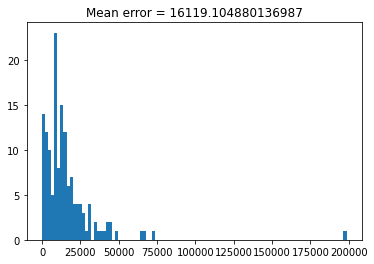

In [11]:
# Benchmark model
K.clear_session()
in_dim = np.shape(X_train)[1]


def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=in_dim, activation='tanh'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model



model = KerasRegressor(build_fn=baseline_model,
                       epochs=1000,
                       batch_size=64,
                       verbose=1,
                       validation_data=(X_val, y_val),
                       callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                    patience=10,
                                                                    min_delta=1e-6,
                                                                    restore_best_weights=True))



model.fit(X_train, y_train)
yp_ann = model.predict(X_val)
err = np.abs(np.exp(yp_ann)-np.exp(y_val))

plt.hist(err,bins=100)

plt.title(f'Mean error = {np.mean(err)}')
plt.show()

C:\Users\lewis\AppData\Local\Temp\ipykernel_11212\2087937150.py:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_model = KerasRegressor(build_fn=baseline_model,


Model: ANN
Model: RF
Best parameters for RF: {'max_depth': 24, 'n_estimators': 70}
Model: XT
Best parameters for XT: {'max_depth': 14, 'n_estimators': 100}
Model: XGBoost
Model: Pois
Best parameters for Pois: {'alpha': 0.2}
Best weights: [0.3929787  0.07038359 0.07213179 0.4548545  0.00965142]


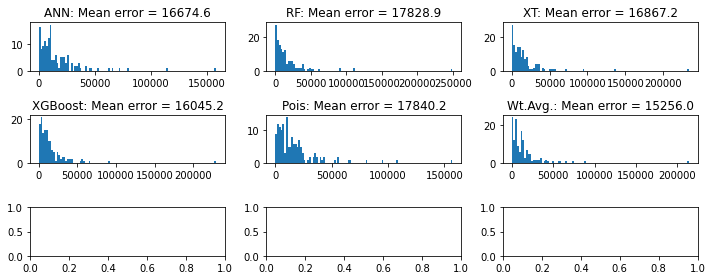

In [150]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, PoissonRegressor, Lasso, ElasticNet

ann_model = KerasRegressor(build_fn=baseline_model,
                       epochs=1000,
                       batch_size=64,
                       verbose=0,
                       validation_data=(X_val, y_val),
                       callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                    patience=10,
                                                                    min_delta=1e-6,
                                                                    restore_best_weights=True))

models = [ann_model,
          RandomForestRegressor(),
          ExtraTreesRegressor(),
          XGBRegressor(eval_metric='mae', max_depth=2, n_estimators = 500),
          PoissonRegressor(max_iter=100000)]

titles = ['ANN',
          'RF',
          'XT',
          'XGBoost',
          'Pois',
          'Wt.Avg.']


pgrid = {'RF': {'n_estimators' : [70,80], 'max_depth' : [16,20,24]},
        'XT': {'n_estimators' : [50,75,100], 'max_depth' : [6,8,10,12,14]},
        'Pois': {'alpha' : [0.2,0.4,0.6,0.8,1]}}

yp = []
err = []
ct = 0
for m in models:
    print(f'Model: {titles[ct]}')
    
    if titles[ct] == 'XGBoost':
        m.fit(X_train,y_train, eval_set=[(X_val,y_val)], verbose=0)
        ypp = m.predict(X_val)
        
    elif titles[ct] == 'ANN':
        m.fit(X_train,y_train)
        ypp = m.predict(X_val)
        
    else:
        cvm = GridSearchCV(m,param_grid=pgrid[titles[ct]]).fit(X_train,y_train)
        ypp = cvm.predict(X_val)
        print(f'Best parameters for {titles[ct]}: {cvm.best_params_}')
        
        
    yp.append(np.exp(ypp.reshape(-1,1)))
    err.append(np.abs(np.exp(ypp)-np.exp(y_val)))
    ct+=1


predictions = yp[0]
for i in range(1,len(yp)):
    predictions = np.concatenate((predictions,yp[i]),axis=1)

best = 9999999999

for i in range(10000):
    w = np.random.rand(np.shape(predictions)[1])
    w = w/np.sum(w)
    yp_avg = np.sum(predictions*w,axis=1)
    err_avg = np.mean(np.abs(np.exp(y_val)-yp_avg))
    
    if err_avg<best:
        best=err_avg
        best_w = w
    

print(f'Best weights: {best_w}')

yp.append(np.sum(predictions*best_w,axis=1))
err.append(np.abs(np.abs(np.exp(y_val)-yp_avg)))


fix,ax = plt.subplots(nrows=3,ncols=3,figsize=(10,4))
ax = ax.flatten()

for i in range(len(yp)):
    ax[i].hist(err[i],bins=100)
    ax[i].set_title(f'{titles[i]}: Mean error = {np.round(np.mean(err[i]),1)}')


plt.tight_layout()

In [70]:
# feed through test set

test_pred_avg = models[0].predict(X_test)*best_w[0]
for i in range(1,len(models)):
    test_pred_avg += models[i].predict(X_test)*best_w[i]





In [71]:
print(np.shape(test_pred_avg))
pred = pd.DataFrame(test_pred_avg)
sub_df = pd.read_csv('sample_submission.csv')
datasets = pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns = ['Id', 'SalePrice']
datasets.to_csv('submission_1.csv',index=False)

(1459,)


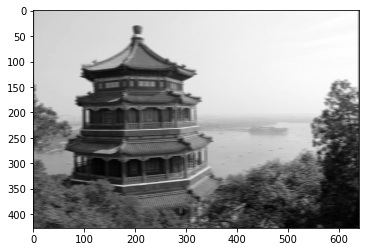

In [39]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255

images = np.array([china,flower])

batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0,:,:,1],cmap='gray')
plt.show()


In [31]:
filters[0,:,:,0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)